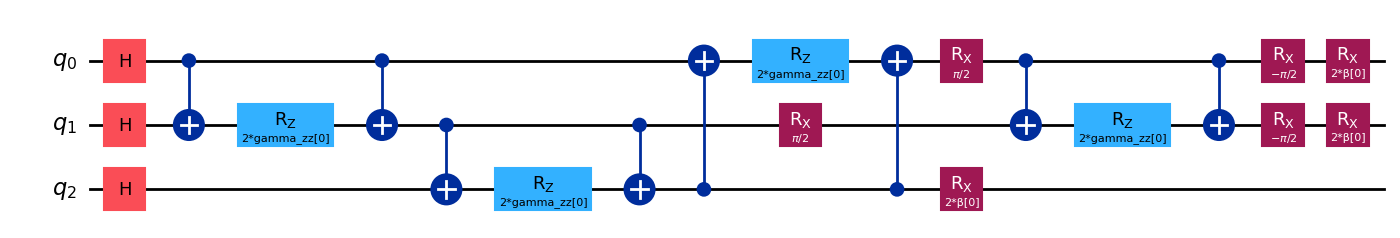

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

def create_qaoa_ansatz(m: int, layers: int = 1) -> QuantumCircuit:
    beta = ParameterVector('β', layers * 2)  # Mixer per qubit
    gamma_zz = ParameterVector('gamma_zz', layers)  # ZZ per pair
    qc = QuantumCircuit(m, name='QAOA_ansatz')
    
    # Initial |+> state
    qc.h(range(m))
    
    for layer in range(layers):
        # Driver HD: ZZ terms (RZ + CNOT)
        for i in range(m):
            j = (i + 1) % m  # Cyclic: i to j
            qc.cx(i, j)
            qc.rz(2 * gamma_zz[layer], j)
            qc.cx(i, j)
        
        #qc.barrier()
        
        # YY on 0-1 (논문 HD)
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        qc.cx(0, 1)
        qc.rz(2 * gamma_zz[layer], 1)
        qc.cx(0, 1)
        qc.rx(-np.pi/2, 0)
        qc.rx(-np.pi/2, 1)
        
        #qc.barrier()
        
        # Mixer HM: RX on all
        for i in range(m):
            qc.rx(2 * beta[layer], i)
    
    return qc


qc1 = create_qaoa_ansatz(3, 1)

qc1.draw('mpl')

In [6]:
# PQCAnalyzer: arbitrary-ansatz compatible (KL, moments, Q) – no providers/Aer
# - Accepts: QuantumCircuit with Parameters, or callables returning a circuit
# - Works with Qiskit Statevector only, Matplotlib one-chart-per-figure

from __future__ import annotations
import inspect
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity


class PQCAnalyzer:
    """
    Analyzer for arbitrary parameterized quantum circuits (PQC).

    Features:
      - Plug ANY ansatz:
          * QuantumCircuit with unbound Parameters (will be bound with theta)
          * callable(theta)->QuantumCircuit
          * callable(n, L, theta)->QuantumCircuit
      - Samples states, computes pairwise overlaps F = |<ψ|φ>|^2
      - KL expressibility vs Haar, frame-potential moments
      - Meyer–Wallach Q & entangling capability (mean Q)
      - Plots: F histogram vs Haar, moment comparison, Q histogram, Ent vs L

    Parameters
    ----------
    n : int
        Number of qubits (only used if your ansatz callable needs it; ignored for fixed circuits).
    L : int
        "Depth" meta (only used if your ansatz callable needs it; ignored for fixed circuits).
    ansatz : QuantumCircuit | callable
        - QuantumCircuit with free Parameters
        - callable(theta)->QuantumCircuit
        - callable(n, L, theta)->QuantumCircuit
    param_count : int | None
        Number of parameters for theta. If None, try to infer from:
          - QuantumCircuit.parameters
          - callable signature (fallback required if cannot infer)
    entangler : str
        Only used for plot titles/labels if you’d like to tag the style (has no functional effect).
    seed : int
        Default RNG seed for sampling utilities.
    """

    # --------------- init & basic props ---------------
    def __init__(
        self,
        n: int,
        L: int,
        ansatz,
        param_count: int | None = None,
        entangler: str = "custom",
        seed: int = 7,
    ):
        self.n = int(n)
        self.L = int(L)
        self.ansatz = ansatz
        self.entangler = entangler
        self.seed = int(seed)

        inferred = self._infer_param_count(ansatz)
        if param_count is not None:
            self._param_count = int(param_count)
        elif inferred is not None:
            self._param_count = int(inferred)
        else:
            raise ValueError(
                "param_count could not be inferred. Please pass param_count explicitly."
            )

    @property
    def d(self) -> int:
        return 2 ** self.n

    @property
    def param_count(self) -> int:
        return self._param_count

    # --------------- ansatz handling ---------------
    def _infer_param_count(self, ansatz) -> int | None:
        """Try to infer number of parameters required for theta."""
        # Case 1: QuantumCircuit with free Parameters
        if isinstance(ansatz, QuantumCircuit):
            return len(ansatz.parameters)

        # Case 2: callable – try to inspect signature
        if callable(ansatz):
            sig = inspect.signature(ansatz)
            # Supported forms: (theta) or (n, L, theta)
            params = list(sig.parameters.values())
            if len(params) == 1:
                # cannot know param_count without building once;
                # user should pass param_count, unless ansatz carries a hint
                return None
            if len(params) == 3:
                # also unknown until build; return None and expect user to pass param_count
                return None

        return None

    def _build_from_callable(self, theta: np.ndarray) -> QuantumCircuit:
        """Build circuit from callable ansatz with signature (theta) or (n, L, theta)."""
        sig = inspect.signature(self.ansatz)
        params = list(sig.parameters.values())
        if len(params) == 1:
            qc = self.ansatz(theta)
        elif len(params) == 3:
            qc = self.ansatz(self.n, self.L, theta)
        else:
            raise TypeError(
                "Callable ansatz must have signature (theta) or (n, L, theta)."
            )
        if not isinstance(qc, QuantumCircuit):
            raise TypeError("Callable ansatz must return a QuantumCircuit.")
        return qc

    def _bind_circuit(self, template: QuantumCircuit, theta: np.ndarray) -> QuantumCircuit:
        params = list(template.parameters)
        if len(params) != len(theta):
            raise ValueError(
                f"Parameter count mismatch: circuit has {len(params)} params, "
                f"got theta of length {len(theta)}"
            )
        mapping = {p: float(v) for p, v in zip(params, theta)}
        try:
            # Qiskit 1.x/2.x
            return template.assign_parameters(mapping, inplace=False)
        except AttributeError:
            # 구버전 테라 호환
            return template.bind_parameters(mapping)

    def make_circuit(self, theta: np.ndarray) -> QuantumCircuit:
        """Build a fully bound QuantumCircuit from the configured ansatz and theta."""
        if len(theta) != self.param_count:
            raise ValueError(
                f"theta length {len(theta)} does not match required param_count {self.param_count}"
            )

        if isinstance(self.ansatz, QuantumCircuit):
            # Clone to avoid mutating the original; bind on the copy
            qc = self.ansatz.copy()
            # If the circuit has no Parameters, still allow 0-length theta
            if len(qc.parameters) > 0:
                qc = self._bind_circuit(qc, theta)
            return qc

        if callable(self.ansatz):
            return self._build_from_callable(theta)

        raise TypeError("ansatz must be a QuantumCircuit or a callable returning a QuantumCircuit.")

    def state_from_theta(self, theta: np.ndarray) -> Statevector:
        return Statevector.from_instruction(self.make_circuit(theta))

    # --------------- sampling utilities ---------------
    def sample_thetas(self, M: int, rng: np.random.Generator) -> np.ndarray:
        """Uniform parameters in [0, 2π). Shape (M, param_count)."""
        if self.param_count == 0:
            return np.zeros((M, 0), dtype=float)
        return rng.uniform(0.0, 2.0 * math.pi, size=(M, self.param_count))

    def sample_states(self, M: int, seed: int | None = None) -> list[Statevector]:
        rng = np.random.default_rng(self.seed if seed is None else seed)
        thetas = self.sample_thetas(M, rng)
        return [self.state_from_theta(th) for th in thetas]

    # --------------- Haar references ---------------
    @staticmethod
    def haar_pdf(F: np.ndarray, d: int) -> np.ndarray:
        return (d - 1) * np.power(1.0 - F, d - 2)

    @staticmethod
    def haar_moment(t: int, d: int) -> float:
        from math import lgamma, exp
        return exp(lgamma(t + 1) + lgamma(d) - lgamma(t + d))

    @staticmethod
    def haar_Q_mean(n: int) -> float:
        N = 2 ** n
        return (N - 2) / (N + 1)

    # --------------- pairwise F & moments ---------------
    @staticmethod
    def _pair_indices(M: int, num_pairs: int | None, rng: np.random.Generator):
        S = M * (M - 1) // 2
        if (num_pairs is None) or (num_pairs >= S):
            for i in range(M):
                for j in range(i + 1, M):
                    yield i, j
            return
        seen = set()
        tries = 0
        while len(seen) < num_pairs and tries < 10 * num_pairs:
            i = rng.integers(0, M)
            j = rng.integers(0, M)
            if i == j:
                tries += 1
                continue
            a, b = (i, j) if i < j else (j, i)
            if (a, b) in seen:
                tries += 1
                continue
            seen.add((a, b))
        for pair in seen:
            yield pair

    @staticmethod
    def empirical_moments(Fs: np.ndarray, t_max: int = 3) -> np.ndarray:
        return np.array([float(np.mean(np.power(Fs, t))) for t in range(1, t_max + 1)])

    def sample_pairwise_F(self, states: list[Statevector], num_pairs: int | None = None,
                          seed: int | None = None) -> np.ndarray:
        rng = np.random.default_rng(self.seed if seed is None else seed)
        M = len(states)
        Fs = []
        for i, j in self._pair_indices(M, num_pairs, rng):
            Fs.append(state_fidelity(states[i], states[j]))
        return np.array(Fs, dtype=float)

    # --------------- KL expressibility & plots ---------------
    def kl_expressibility(self, Fs: np.ndarray, bins: int = 60) -> tuple[float, tuple[np.ndarray, np.ndarray, np.ndarray]]:
        hist, edges = np.histogram(Fs, bins=bins, range=(0.0, 1.0), density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]
        p_hat = hist
        p_haar = self.haar_pdf(centers, self.d)
        eps = 1e-12
        kl = float(np.sum(p_hat * np.log((p_hat + eps) / (p_haar + eps))) * width)
        return kl, (centers, p_hat, p_haar)

    def plot_F_histogram(self, Fs: np.ndarray, bins: int = 60, title: str | None = None, savepath: str | None = None):
        fig = plt.figure()
        plt.hist(Fs, bins=bins, range=(0.0, 1.0), density=True, alpha=0.6, label="Empirical F histogram")
        grid = np.linspace(0, 1, 400)
        plt.plot(grid, self.haar_pdf(grid, self.d), label="Haar pdf")
        plt.xlabel("F = |<psi|phi>|^2")
        plt.ylabel("Density")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    def plot_moment_comparison(self, Fs: np.ndarray, t_max: int = 3, title: str | None = None, savepath: str | None = None):
        emp = self.empirical_moments(Fs, t_max=t_max)
        haar = np.array([self.haar_moment(t, self.d) for t in range(1, t_max + 1)])
        x = np.arange(1, t_max + 1, dtype=float)
        width = 0.35
        fig = plt.figure()
        plt.bar(x - width / 2, emp, width, label="Empirical")
        plt.bar(x + width / 2, haar, width, label="Haar")
        plt.xticks(x, [f"t={t}" for t in range(1, t_max + 1)])
        plt.ylabel("Moment  E[F^t]")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # --------------- Meyer–Wallach Q & capability ---------------
    @staticmethod
    def _purity(dm: DensityMatrix) -> float:
        data = dm.data
        return float(np.real(np.trace(data @ data)))

    @staticmethod
    def meyer_wallach_Q(state_or_circuit) -> float:
        if isinstance(state_or_circuit, Statevector):
            sv = state_or_circuit
        elif isinstance(state_or_circuit, QuantumCircuit):
            sv = Statevector.from_instruction(state_or_circuit)
        else:
            sv = Statevector(np.asarray(state_or_circuit))
        n = sv.num_qubits
        rho = DensityMatrix(sv)
        total = 0.0
        for j in range(n):
            others = [q for q in range(n) if q != j]
            rho_j = partial_trace(rho, others)
            total += (1.0 - PQCAnalyzer._purity(rho_j))
        Q = (2.0 / n) * total
        return float(np.clip(Q, 0.0, 1.0))

    def entangling_capability(self, M: int = 200, seed: int | None = None) -> tuple[float, float, float, np.ndarray]:
        rng = np.random.default_rng(self.seed if seed is None else seed)
        thetas = self.sample_thetas(M, rng)
        Qs = []
        for th in thetas:
            qc = self.make_circuit(th)
            Qs.append(self.meyer_wallach_Q(qc))
        Qs = np.array(Qs, dtype=float)
        Ent_mean, Ent_std = float(np.mean(Qs)), float(np.std(Qs))
        return Ent_mean, Ent_std, self.haar_Q_mean(self.n), Qs

    def plot_Q_histogram(self, Qs: np.ndarray, bins: int = 40, title: str | None = None, savepath: str | None = None):
        q_haar = self.haar_Q_mean(self.n)
        fig = plt.figure()
        plt.hist(Qs, bins=bins, range=(0.0, 1.0), density=True, alpha=0.7, label="Empirical Q")
        plt.axvline(q_haar, linestyle="--", label=f"Haar mean Q = {q_haar:.3f}")
        plt.xlabel("Q (Meyer–Wallach)")
        plt.ylabel("Density")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # --------------- end-to-end helpers ---------------
    def run_expressibility_pipeline(self, M: int = 240, num_pairs: int = 5000,
                                   bins: int = 60, seed: int | None = None,
                                   out_prefix: str | None = None):
        states = self.sample_states(M=M, seed=seed)
        Fs = self.sample_pairwise_F(states, num_pairs=num_pairs, seed=seed)
        kl, pack = self.kl_expressibility(Fs, bins=bins)

        if out_prefix is not None:
            self.plot_F_histogram(
                Fs, bins=bins,
                title=f"F histogram vs Haar (n={self.n}, L={self.L}, ent={self.entangler})",
                savepath=f"{out_prefix}_hist.png"
            )
            self.plot_moment_comparison(
                Fs, t_max=3,
                title=f"Moment comparison (n={self.n}, L={self.L}, ent={self.entangler})",
                savepath=f"{out_prefix}_moments.png"
            )
        return kl, Fs, pack

    def run_Q_pipeline(self, M: int = 300, bins: int = 40,
                       seed: int | None = None, L_list=None, out_prefix: str | None = None):
        meanQ, stdQ, qH, Qs = self.entangling_capability(M=M, seed=seed)
        if out_prefix is not None:
            self.plot_Q_histogram(
                Qs, bins=bins,
                title=f"Q distribution (n={self.n}, L={self.L}, ent={self.entangler})",
                savepath=f"{out_prefix}_Qhist.png"
            )
        return meanQ, stdQ, qH, Qs

    # ---------- Metric vs L (KL or Q) ----------
    def _KL_vs_L(self, L_list, M=240, num_pairs=5000, bins=60, seed: int | None = None):
        rng = np.random.default_rng(self.seed if seed is None else seed)
        KLs = []
        for L in L_list:
            tmp = PQCAnalyzer(
                self.n, int(L),
                self.ansatz,
                param_count=2*int(L),        # ★ 여기도 동일
                entangler=self.entangler,
                seed=int(rng.integers(0, 10_000_000))
            )
            states = tmp.sample_states(M=M, seed=int(rng.integers(0, 10_000_000)))
            Fs = tmp.sample_pairwise_F(states, num_pairs=num_pairs, seed=int(rng.integers(0, 10_000_000)))
            kl, _ = tmp.kl_expressibility(Fs, bins=bins)
            KLs.append(float(kl))
        return np.array(L_list, dtype=int), np.array(KLs, dtype=float)

    def _Q_vs_L(self, L_list, M=300, seed: int | None = None):
        rng = np.random.default_rng(self.seed if seed is None else seed)
        means, stds = [], []
        for L in L_list:
            tmp = PQCAnalyzer(
                self.n, int(L),
                self.ansatz,
                param_count=2*int(L),        # ★ 포인트: L마다 2*L로 설정
                entangler=self.entangler,
                seed=int(rng.integers(0, 10_000_000))
            )
            m, st, qh, _ = tmp.entangling_capability(M=M, seed=int(rng.integers(0, 10_000_000)))
            means.append(float(m)); stds.append(float(st))
        return (np.array(L_list, dtype=int),
                np.array(means, dtype=float),
                np.array(stds, dtype=float),
                self.haar_Q_mean(self.n))
    # ---------- Find saturation depth L* ----------
    @staticmethod
    def _find_saturation_L(L_list, values, metric="Q", eps=1e-2, window=2):
        vals = np.asarray(values, dtype=float)
        if metric.upper() == "KL":
            imp = vals[:-1] - vals[1:]      # decrease is good
        else:
            imp = vals[1:] - vals[:-1]      # increase is good

        count = 0
        for i in range(1, len(vals)):
            if imp[i-1] < eps:
                count += 1
            else:
                count = 0
            if count >= window:
                return int(L_list[i])
        return None

    # ---------- Plot with saturation marker ----------
    def _plot_with_saturation(self, L_list, y, metric="Q", yerr=None,
                              haar_line=False, L_star=None, title=None, savepath=None):
        fig = plt.figure()
        if yerr is not None:
            plt.errorbar(L_list, y, yerr=yerr, marker="o", linestyle="-", label=f"{metric} vs L")
        else:
            plt.plot(L_list, y, marker="o", linestyle="-", label=f"{metric} vs L")

        if haar_line and metric.upper() == "Q":
            qh = self.haar_Q_mean(self.n)
            plt.axhline(qh, linestyle="--", label=f"Haar mean Q = {qh:.3f}")

        if L_star is not None:
            plt.axvline(L_star, linestyle=":", label=f"Saturation L* = {L_star}")

        plt.xlabel("Depth L")
        plt.ylabel("Mean Q" if metric.upper()=="Q" else "KL to Haar")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # ---------- Public helpers ----------
    def find_and_plot_Q_saturation(self, L_list, M=300, seed: int | None = None,
                                   eps=1e-2, window=2, savepath=None):
        Ls, means, stds, qh = self._Q_vs_L(L_list, M=M, seed=seed)
        L_star = self._find_saturation_L(Ls, means, metric="Q", eps=eps, window=window)
        self._plot_with_saturation(Ls, means, metric="Q", yerr=stds,
                                   haar_line=True, L_star=L_star,
                                   title=f"Mean Q vs L (n={self.n}, entangler={self.entangler})",
                                   savepath=savepath)
        return L_star, Ls, means, stds

    def find_and_plot_KL_saturation(self, L_list, M=240, num_pairs=5000, bins=60,
                                    seed: int | None = None, eps=5e-3, window=2, savepath=None):
        Ls, KLs = self._KL_vs_L(L_list, M=M, num_pairs=num_pairs, bins=bins, seed=seed)
        L_star = self._find_saturation_L(Ls, KLs, metric="KL", eps=eps, window=window)
        self._plot_with_saturation(Ls, KLs, metric="KL", yerr=None,
                                   haar_line=False, L_star=L_star,
                                   title=f"KL expressibility vs L (n={self.n}, entangler={self.entangler})",
                                   savepath=savepath)
        return L_star, Ls, KLs

KL expressibility: 0.9401316407769486
Mean Q = 0.7895 ± 0.2067 (Haar mean 0.8235)
Q saturation L* = 7


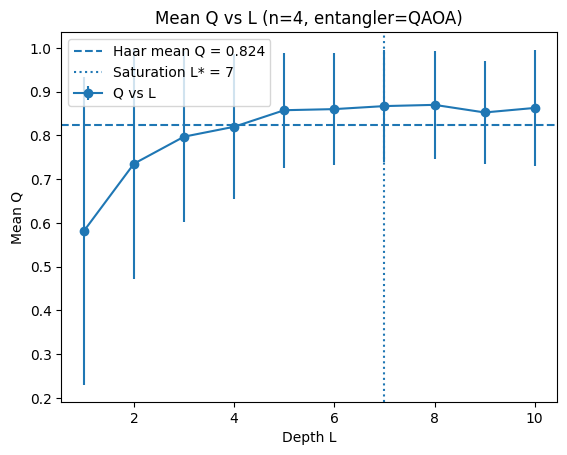

In [7]:
# --- 1) 당신이 만든 QAOA ansatz 그대로 사용 ---
# def create_qaoa_ansatz(m: int, layers: int = 1) -> QuantumCircuit:
#     ... (당신 코드)

import re
import numpy as np

# --- 2) PQCAnalyzer가 요구하는 시그니처의 래퍼: (n, L, theta) -> QuantumCircuit ---
def qaoa_wrapper(n: int, L: int, theta):
    """Bind theta to the parameters of create_qaoa_ansatz(n, L)."""
    qc = create_qaoa_ansatz(n, layers=L)

    # 파라미터를 안정적으로 정렬: 이름(예: 'gamma_zz[0]', 'β[0]')의 (base, index)로 정렬
    def key_fn(p):
        name = p.name  # e.g. "gamma_zz[3]" or "β[1]"
        m = re.match(r"^([^\[]+)\[(\d+)\]$", name)
        if m:
            base, idx = m.group(1), int(m.group(2))
        else:
            base, idx = name, 0
        return (base, idx)

    params = sorted(list(qc.parameters), key=key_fn)

    theta = np.asarray(theta, dtype=float).ravel()
    if len(params) != len(theta):
        raise ValueError(f"theta 길이({len(theta)})가 회로 파라미터 수({len(params)})와 다릅니다.")

    bind_map = {p: float(v) for p, v in zip(params, theta)}
    return qc.assign_parameters(bind_map, inplace=False)

# --- 3) PQCAnalyzer에 꽂아서 실행 ---
# PQCAnalyzer는 "임의 안사츠" 버전을 사용하세요 (제가 앞서 드린 버전).
# 핵심: param_count = 사용되는 파라미터 개수 = 2 * L (beta: L개, gamma_zz: L개)
n = 4          # qubit 수
L = 3          # QAOA layer 수
param_count = 2 * L

an = PQCAnalyzer(
    n=n,
    L=L,
    ansatz=qaoa_wrapper,      # (n, L, theta) 시그니처
    param_count=param_count,  # 파라미터 개수 명시
    entangler="QAOA"
)

# --- 4) 예시 1: Expressibility 파이프라인 (KL) ---
kl, Fs, _ = an.run_expressibility_pipeline(
    M=200,          # 샘플 state 수
    num_pairs=3000, # 페어 수 (무작위)
    bins=60,
    seed=7
)
print("KL expressibility:", kl)

# --- 5) 예시 2: Entangling capability (Q) ---
meanQ, stdQ, qH, Qs = an.run_Q_pipeline(M=300, seed=7)
print(f"Mean Q = {meanQ:.4f} ± {stdQ:.4f} (Haar mean {qH:.4f})")

# --- 6) (선택) L에 따른 포화 깊이 찾기 ---
L_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
L_star, Ls, means, stds = an.find_and_plot_Q_saturation(L_list, M=200, seed=7)
print("Q saturation L* =", L_star)

KL expressibility: 1.0199802250809704
<Q>: 0.7895 ± 0.2067 (Haar mean 0.8235)
Q saturation L* = 7
KL saturation L* = None


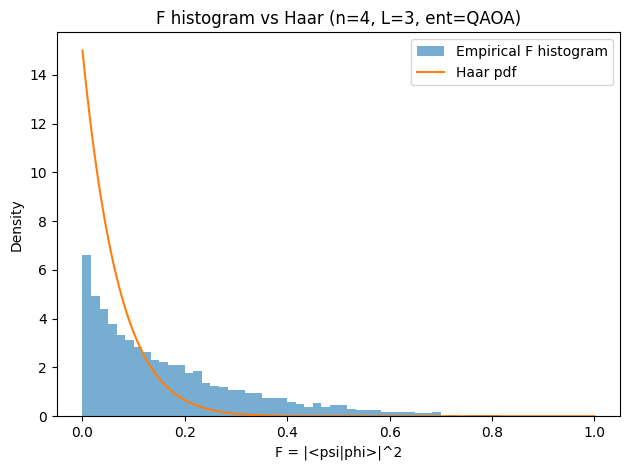

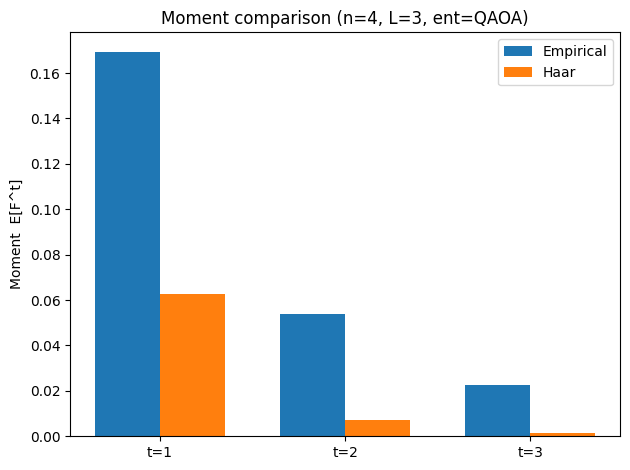

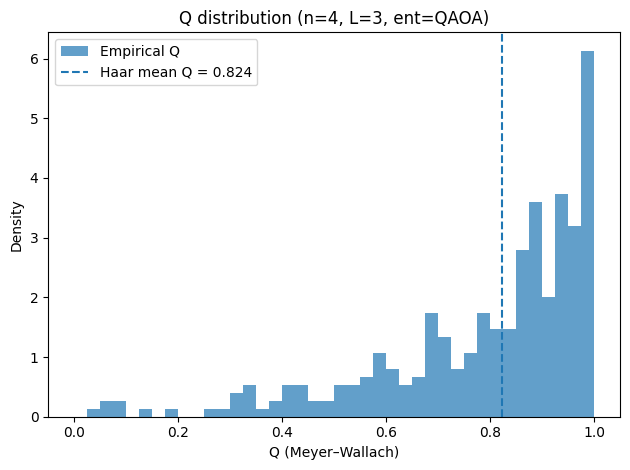

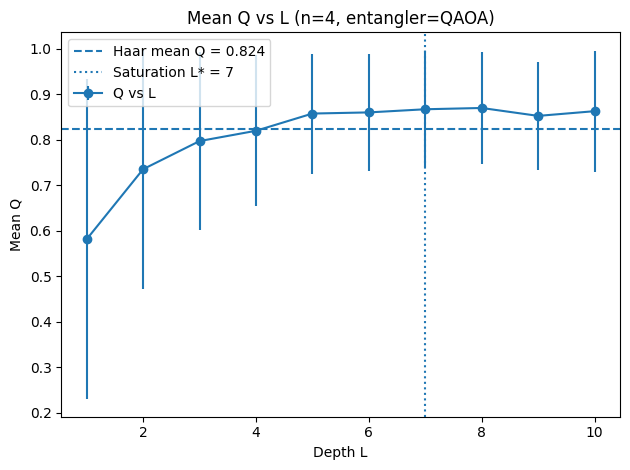

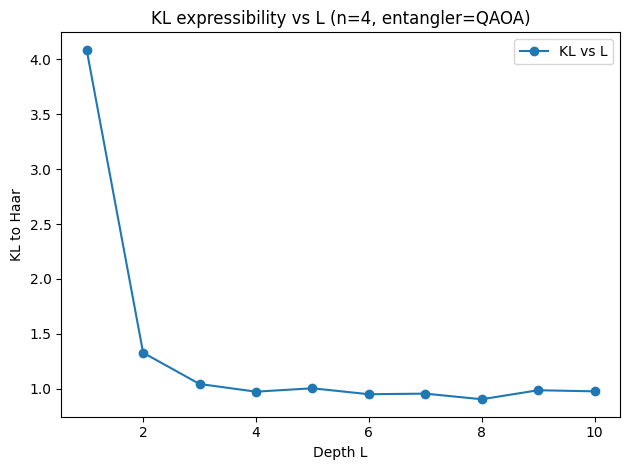

In [8]:
# === 0) 선행: 네가 정의한 ansatz ===
# def create_qaoa_ansatz(m: int, layers: int = 1) -> QuantumCircuit:
#     ... (네 코드)

import re
import numpy as np

# (n, L, theta) -> QuantumCircuit 형태의 래퍼
def qaoa_wrapper(n: int, L: int, theta):
    qc = create_qaoa_ansatz(n, layers=L)

    # 파라미터를 이름(예: 'gamma_zz[0]', 'β[0]') 기준으로 안정 정렬
    def key_fn(p):
        m = re.match(r"^([^\[]+)\[(\d+)\]$", p.name)
        if m:
            return (m.group(1), int(m.group(2)))
        return (p.name, 0)

    params = sorted(list(qc.parameters), key=key_fn)

    theta = np.asarray(theta, dtype=float).ravel()
    if len(params) != len(theta):
        raise ValueError(f"theta 길이({len(theta)})가 회로 파라미터 수({len(params)})와 다릅니다.")

    bind_map = {p: float(v) for p, v in zip(params, theta)}
    # Qiskit 2.x 호환: assign_parameters 사용
    return qc.assign_parameters(bind_map, inplace=False)


# === 1) 클래스 초기화: 임의 안사츠 지원 버전 PQCAnalyzer 사용 ===
#   - param_count = 2*L  (beta: L개, gamma_zz: L개)
n = 4
L = 3
param_count = 2 * L

an = PQCAnalyzer(
    n=n,
    L=L,
    ansatz=qaoa_wrapper,     # 커스텀 안사츠 래퍼
    param_count=param_count, # 파라미터 개수 명시
    entangler="QAOA"         # 라벨(그래프 제목용)
)

# === 2) 표현가능성 파이프라인 (KL + 그림 저장) ===
kl, Fs, _ = an.run_expressibility_pipeline(
    M=240, num_pairs=5000, bins=60, seed=7, out_prefix="expressibility"
)
print("KL expressibility:", kl)

# === 3) 얽힘능력 파이프라인 (Q 히스토그램 + Ent vs L 곡선 저장) ===
# Ent vs L을 그리고 싶으면 L_list를 별도로 돌려야 해요.
meanQ, stdQ, qH, Qs = an.run_Q_pipeline(
    M=300, bins=40, seed=7, out_prefix="entangling"
)
print(f"<Q>: {meanQ:.4f} ± {stdQ:.4f} (Haar mean {qH:.4f})")

# --- Entanglement vs L 곡선 & 포화깊이 ---
L_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# 각 L에서 param_count를 2*L로 맞춰야 하므로, 내부 sweep 함수가 그리도록 제공된
# find_and_plot_Q_saturation / find_and_plot_KL_saturation 를 사용
L_star_Q, Ls, means, stds = an.find_and_plot_Q_saturation(L_list, M=200, seed=7, savepath="entangling_Ent_vs_L.png")
print("Q saturation L* =", L_star_Q)

L_star_KL, Ls2, KLs = an.find_and_plot_KL_saturation(L_list, M=240, num_pairs=5000, bins=60, seed=7, savepath="expressibility_KL_vs_L.png")
print("KL saturation L* =", L_star_KL)